In [5]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from utils import get_train_test, get_columns


In [2]:
window_length = 12
horizon = 4
total_size = int(24*4*365*2.5)
excluded_columns = ['Datetime',
                    'Resolution code',
                    'Total Load',
                    'Most recent forecast',
                    'Most recent P10',
                    'Most recent P90',
                    'Day-ahead 6PM forecast',
                    'Day-ahead 6PM P10',
                    'Day-ahead 6PM P90',
                    'Week-ahead forecast',
                    #'Total Load Interpolated',
                    'Year',
                    #'Month',
                    #'Day',
                    #'Hour',
                    #'Minute',
                    'Season',
                    'Lockdown',
                    'Difference with previous load',
                    'Difference with previous load interpolated',
                    'Total Load Interpolated Persistence',
                    'Total Load Persistence'
                   ]

In [ ]:
X_train, Y_train, X_test, Y_test = get_train_test(window_length, horizon, total_size, excluded_columns)

In [4]:
print("Training Input shape:", X_train.shape)
print("Testing Input shape:", X_test.shape)
print("Training Output shape:", Y_train.shape)
print("Training Output shape:", Y_test.shape)

Training Input shape: (21150, 60)
Testing Input shape: (744, 60)
Training Output shape: (21150, 4)
Training Output shape: (744, 4)


In [5]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


tf.keras.backend.clear_session()

model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='linear'))
model.add(Dense(16, activation='linear'))
model.add(Dense(4, activation='linear'))

optimizer = Adam(learning_rate=0.0003)


model.compile(optimizer=optimizer, loss='mean_squared_error')


checkpoint = ModelCheckpoint(filepath='best_model.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min', 
                             verbose=1)

history = model.fit(X_train, Y_train, 
                    validation_split=0.3, 
                    epochs=40, 
                    batch_size=8, 
                    shuffle=True, 
                    verbose=1, 
                    callbacks=[checkpoint])

Epoch 1/40
1839/1851 [============================>.] - ETA: 0s - loss: 1097237.1250
Epoch 1: val_loss improved from inf to 188783.17188, saving model to best_model.h5
1851/1851 [==============================] - 6s 3ms/step - loss: 1091390.1250 - val_loss: 188783.1719
Epoch 2/40
1838/1851 [============================>.] - ETA: 0s - loss: 97368.7422
Epoch 2: val_loss improved from 188783.17188 to 90377.52344, saving model to best_model.h5
1851/1851 [==============================] - 6s 3ms/step - loss: 97239.3984 - val_loss: 90377.5234
Epoch 3/40
1841/1851 [============================>.] - ETA: 0s - loss: 66050.1484
Epoch 3: val_loss improved from 90377.52344 to 61880.76562, saving model to best_model.h5
1851/1851 [==============================] - 6s 3ms/step - loss: 65975.2500 - val_loss: 61880.7656
Epoch 4/40
1841/1851 [============================>.] - ETA: 0s - loss: 56403.2617
Epoch 4: val_loss did not improve from 61880.76562
1851/1851 [==============================] - 6s 3ms

In [6]:
model = tf.keras.models.load_model('best_model.h5')

In [7]:
y_hat_mlp = model.predict(X_test)

24/24 [==============================] - 0s 915us/step


In [8]:
pd.DataFrame({"Prediction": y_hat_mlp.flatten()}).to_csv("mlp.csv", index=False)

In [9]:
pd.DataFrame({"Total Load Interpolated": Y_test.flatten()}).to_csv("truth.csv", index=False)

In [2]:
predictions = pd.read_csv('mlp.csv')
truth = pd.read_csv("truth.csv")

In [7]:
def plot_true_vs_predicted(y_true, y_pred, time=None):
    if time is None:
        time = np.arange(len(y_true))
    
    plt.figure(figsize=(18, 6))
    plt.plot(time, y_true, color='blue', label='True Values')
    plt.plot(time, y_pred, color='red', label='Predicted Values')
    
    plt.ylabel('Total Load')
    plt.title('True Values vs Predicted Values')
    plt.legend()
    plt.show()

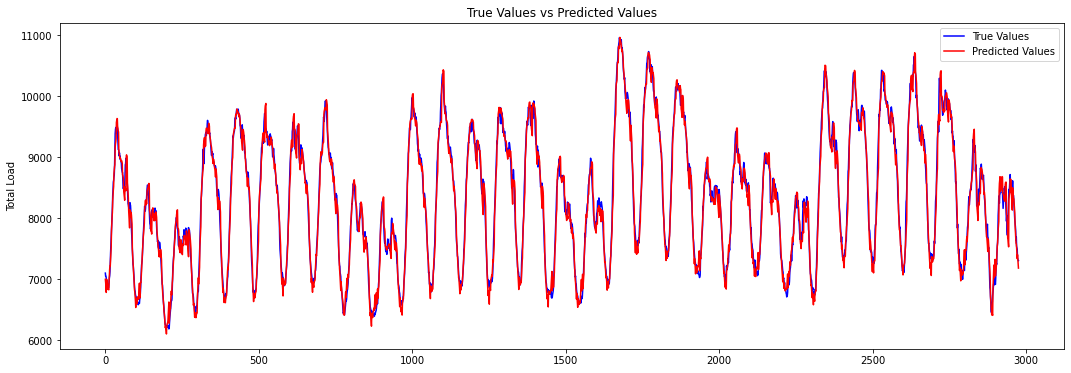

In [8]:
plot_true_vs_predicted(truth["Total Load Interpolated"], predictions["Prediction"])

In [6]:

t0_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][::4], predictions["Prediction"][::4]))
t1_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][1::4], predictions["Prediction"][1::4]))
t2_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][2::4], predictions["Prediction"][2::4]))
t3_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][3::4], predictions["Prediction"][3::4]))

t0_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][::4], predictions["Prediction"][::4])
t1_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][1::4], predictions["Prediction"][1::4])
t2_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][2::4], predictions["Prediction"][2::4])
t3_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][3::4], predictions["Prediction"][3::4])

print("|Model Name|RMSE t+1|RMSE t+2|RMSE t+3|RMSE t+4|MAPE t+1|MAPE t+2|MAPE t+3|MAPE t+4|")
print("| |", str(t0_rmse)[:7], "|", str(t1_rmse)[:7], "|", str(t2_rmse)[:7], "|", str(t3_rmse)[:7],
      "|", str(t0_mape)[:7], "|", str(t1_mape)[:7], "|", str(t2_mape)[:7], "|", str(t3_mape)[:7], "|", sep="")

|Model Name|RMSE t+1|RMSE t+2|RMSE t+3|RMSE t+4|MAPE t+1|MAPE t+2|MAPE t+3|MAPE t+4|
| |88.8970|132.369|162.625|196.921|0.00849|0.01240|0.01551|0.01879|
